In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


# Data Cleaning


In [2]:
df = pd.read_csv('steam_game_reviews.csv')

C:\Users\yapch\AppData\Local\Temp\ipykernel_12192\3356819961.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('steam_game_reviews.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992153 entries, 0 to 992152
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review          991650 non-null  object
 1   hours_played    992153 non-null  object
 2   helpful         992153 non-null  object
 3   funny           992153 non-null  object
 4   recommendation  992153 non-null  object
 5   date            992153 non-null  object
 6   game_name       992153 non-null  object
 7   username        992072 non-null  object
dtypes: object(8)
memory usage: 60.6+ MB


In [4]:
df["hours_played"] = pd.to_numeric(df["hours_played"], errors="coerce")
df["helpful"] = pd.to_numeric(df["helpful"], errors="coerce")
df["funny"] = pd.to_numeric(df["funny"], errors="coerce")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992153 entries, 0 to 992152
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   review          991650 non-null  object 
 1   hours_played    918437 non-null  float64
 2   helpful         989265 non-null  float64
 3   funny           991163 non-null  float64
 4   recommendation  992153 non-null  object 
 5   date            992153 non-null  object 
 6   game_name       992153 non-null  object 
 7   username        992072 non-null  object 
dtypes: float64(3), object(5)
memory usage: 60.6+ MB


In [5]:
df.dropna(inplace=True)
df.isnull().sum()

review            0
hours_played      0
helpful           0
funny             0
recommendation    0
date              0
game_name         0
username          0
dtype: int64

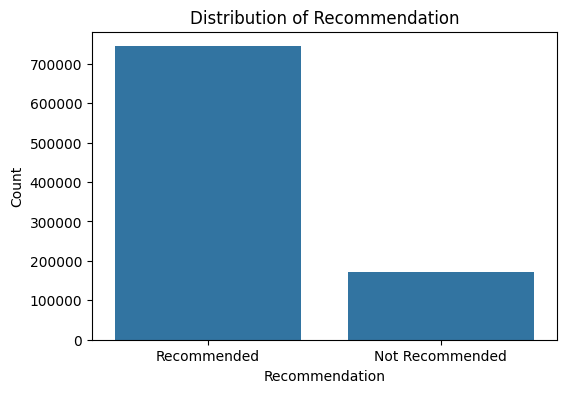

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='recommendation', data=df)
plt.title('Distribution of Recommendation')
plt.xlabel('Recommendation')
plt.ylabel('Count')
plt.show()

In [7]:
recommended = df[df['recommendation'] == 'Recommended']
not_recommended = df[df['recommendation'] == 'Not Recommended']

n_not_recommended = 20000
n_recommended = int(n_not_recommended * 8 / 2)

sampled_recommended = recommended.sample(n=n_recommended, random_state=42)
sampled_not_recommended = not_recommended.sample(n=n_not_recommended, random_state=42)

df_sample = pd.concat([sampled_recommended, sampled_not_recommended]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df_sample['recommendation'].value_counts())

recommendation
Recommended        80000
Not Recommended    20000
Name: count, dtype: int64


# Data Preproccesing

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yapch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yapch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yapch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\yapch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [10]:
def preprocess_text(text):
    # 1. Text Normalization (Lowercasing)
    text = text.lower()

    # 2. Tokenization
    tokens = word_tokenize(text)

    # 3. Stopword Removal and Lemmatization
    processed_tokens = []
    for word in tokens:
        if word.isalpha() and word not in stop_words:
            lemma = lemmatizer.lemmatize(word)
            processed_tokens.append(lemma)

    # Join tokens back into a string
    return " ".join(processed_tokens)

In [11]:
df_sample['processed_review'] = df_sample['review'].apply(preprocess_text)

print("Processed Reviews:")
print(df_sample['processed_review'].head())

Processed Reviews:
0                     vvbetter valorantbetter valorant
1    game named nfs heat cell shaded map basically ...
2              great time killer especially steam deck
3    early access review thing ca wash hand really ...
4    fact game even next gen graphic pc kind insane...
Name: processed_review, dtype: object


# EDA

C:\Users\yapch\AppData\Local\Temp\ipykernel_12192\3392208040.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_values.index, y=count_values.values, palette='magma')


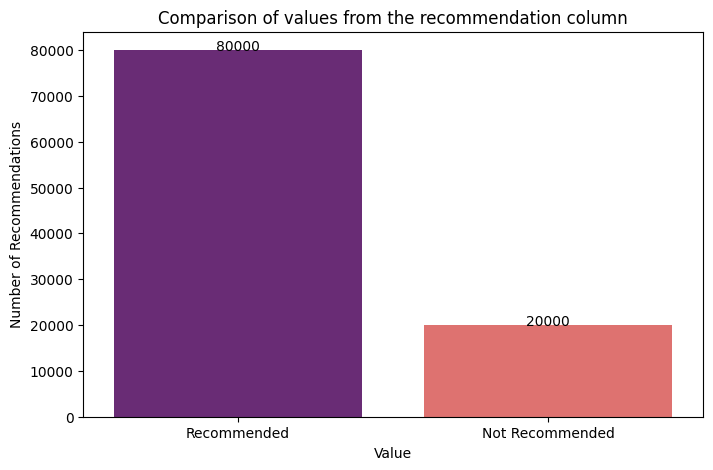

In [12]:
count_values = df_sample['recommendation'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=count_values.index, y=count_values.values, palette='magma')
plt.title('Comparison of values ​​from the recommendation column')
plt.xlabel('Value')
plt.ylabel('Number of Recommendations')
for i, v in enumerate(count_values.values):
    plt.text(i, v + 0.1, str(v), ha='center')

plt.show()

In [13]:
data = df_sample['date']
df2 = pd.DataFrame(data)

def preprocess_dates(date_str):
    if ',' not in date_str:
        return f"{date_str}, 2024"
    return date_str

df_sample['date'] = df_sample['date'].apply(preprocess_dates)

df_sample['date'] = pd.to_datetime(df_sample['date'], format='mixed')

df_sample['year'] = df_sample['date'].dt.year

recommendation_counts_per_year = df_sample.groupby(['year', 'recommendation']).size().unstack(fill_value=0)

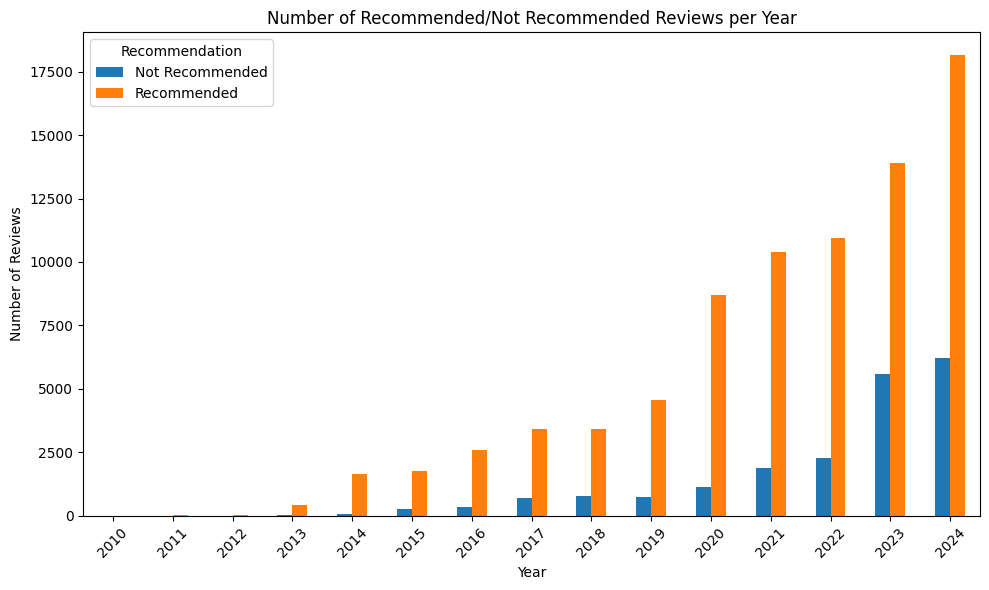

In [14]:
recommendation_counts_per_year.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Recommended/Not Recommended Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend(title='Recommendation')
plt.tight_layout()
plt.show()

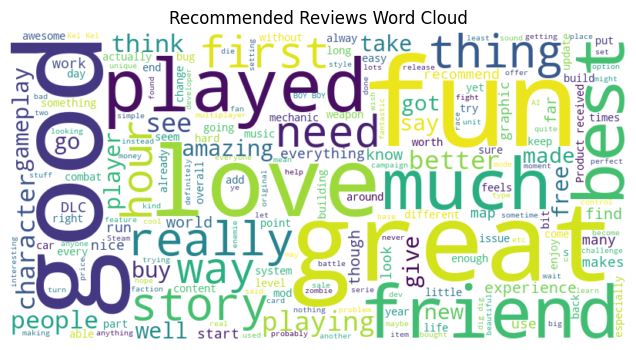

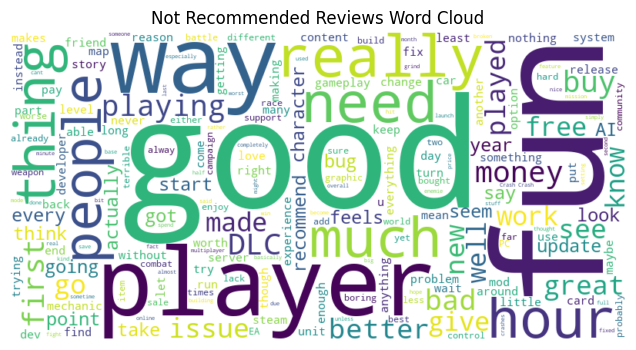

In [15]:
recommended_reviews = " ".join(df_sample[df_sample['recommendation'].str.lower() == 'recommended']['review'].dropna())
not_recommended_reviews = " ".join(df_sample[df_sample['recommendation'].str.lower() == 'not recommended']['review'].dropna())

stopwords = set(STOPWORDS)
stopwords.update(["game", "games", "play", "time", "one", "get", "early", "access", "make", "even", "review", "want", "still", "will", "feel", "lot", "now"]) # Adding specific game-related words to the list of stopwords

if len(recommended_reviews) > 0:
  wc_recommended = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords).generate(recommended_reviews)
  plt.figure(figsize=(8, 4))
  plt.title("Recommended Reviews Word Cloud")
  plt.imshow(wc_recommended, interpolation="bilinear")
  plt.axis("off")
  plt.show()
else:
    print("No 'recommended' reviews found to generate word cloud.")

if len(not_recommended_reviews) > 0:
  wc_not_recommended = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords).generate(not_recommended_reviews)
  plt.figure(figsize=(8, 4))
  plt.title("Not Recommended Reviews Word Cloud")
  plt.imshow(wc_not_recommended, interpolation="bilinear")
  plt.axis("off")
  plt.show()
else:
  print("No 'not recommended' reviews found to generate word cloud.")

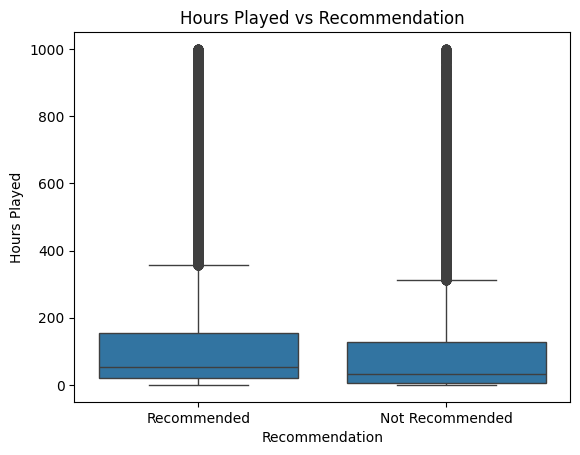

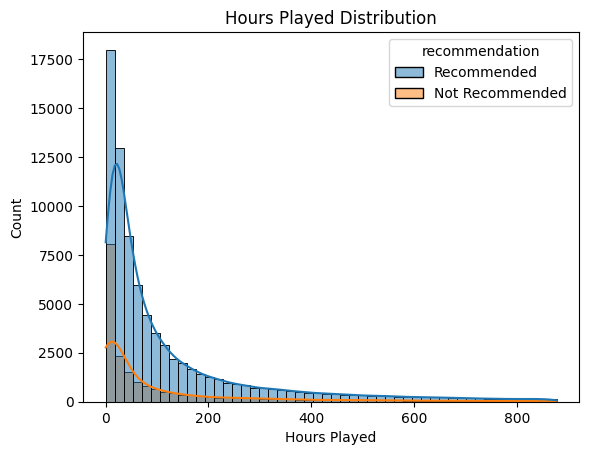

In [16]:
# Distribution of hours played for each recommendation type
sns.boxplot(data=df_sample, x='recommendation', y='hours_played')
plt.title("Hours Played vs Recommendation")
plt.xlabel("Recommendation")
plt.ylabel("Hours Played")
plt.show()

# Filter extreme outliers for better visualisation
df_filtered = df_sample[df_sample['hours_played'] < df_sample['hours_played'].quantile(0.99)]
sns.histplot(data=df_filtered, x='hours_played', hue='recommendation', kde=True, bins=50)
plt.title("Hours Played Distribution")
plt.xlabel("Hours Played")
plt.show()

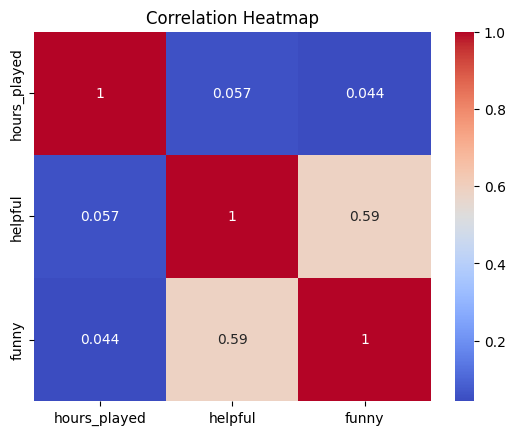

In [17]:
sns.heatmap(df_sample[['hours_played', 'helpful', 'funny']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

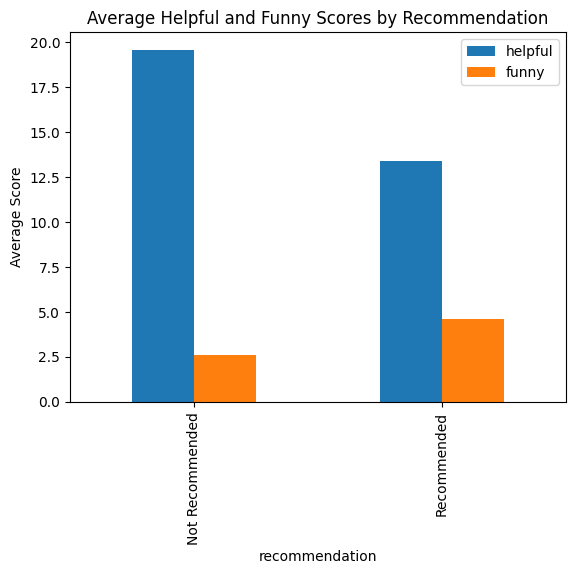

In [18]:
df_sample.groupby('recommendation')[['helpful', 'funny']].mean().plot(kind='bar')
plt.title("Average Helpful and Funny Scores by Recommendation")
plt.ylabel("Average Score")
plt.show()

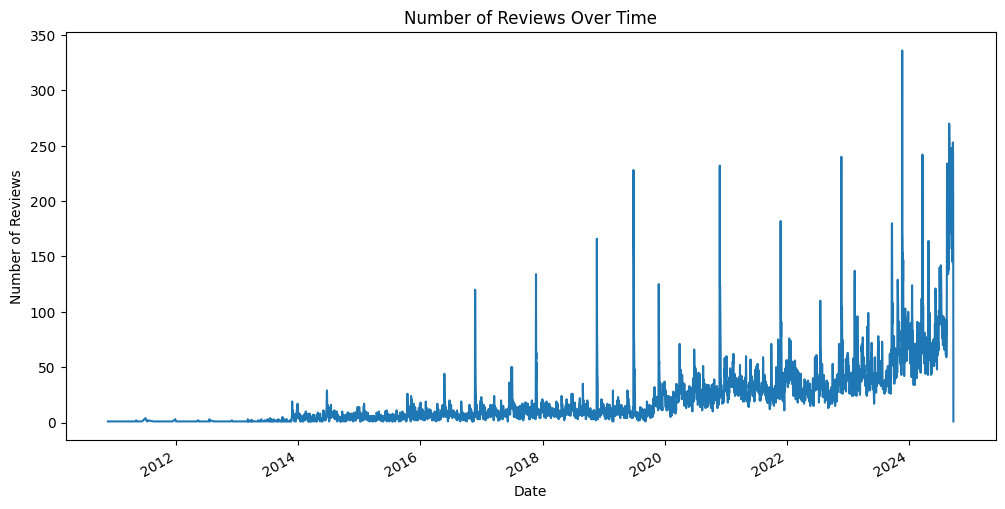

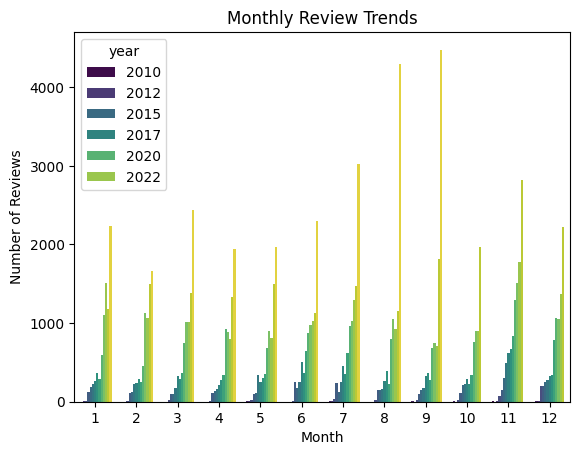

In [19]:
df_sample['date'].value_counts().sort_index().plot(kind='line', figsize=(12, 6))
plt.title("Number of Reviews Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.show()

# Extract month or year for additional trends
df_sample['year'] = df_sample['date'].dt.year
df_sample['month'] = df_sample['date'].dt.month

# Monthly trends
sns.countplot(data=df_sample, x='month', hue='year', palette='viridis')
plt.title("Monthly Review Trends")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.show()

In [20]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sample['processed_review'])

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"This matrix has {tfidf_matrix.shape[0]} documents (reviews) and {tfidf_matrix.shape[1]} unique features (words).")
print("TF-IDF features successfully generated. This sparse matrix is ready for Traditional ML Models.")


TF-IDF Matrix Shape: (100000, 5000)
This matrix has 100000 documents (reviews) and 5000 unique features (words).
TF-IDF features successfully generated. This sparse matrix is ready for Traditional ML Models.


In [21]:
glove_embedding_dim = 100
glove_path = 'glove.6B.100d.txt'

In [22]:
def load_glove_embeddings(path):
    embeddings_index = {}
    if not os.path.exists(path):
        print(f"ERROR: GloVe file '{path}' not found.")
        return {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [23]:
embedding_index = load_glove_embeddings(glove_path)

In [24]:
def create_avg_word_embedding(text_tokens_string, embeddings_index, embedding_dim):
    tokens = text_tokens_string.split()
    vectors = []
    for word in tokens:
        if word in embeddings_index:
            vectors.append(embeddings_index[word])
    
    if not vectors:
        return np.zeros(embedding_dim)
    
    return np.mean(vectors, axis=0)

In [25]:
df_sample['glove_features'] = df_sample['review'].apply(
    lambda x: create_avg_word_embedding(x, embedding_index, glove_embedding_dim).tolist()
)

In [26]:
glove_features_matrix = np.array(df_sample['glove_features'].tolist())

print(f"Shape of GloVe features matrix: {glove_features_matrix.shape}")

Shape of GloVe features matrix: (100000, 100)


In [27]:
class ReviewsDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        return item

In [28]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [30]:
dataset = ReviewsDataset(df_sample['review'].tolist(), bert_tokenizer, 64)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

In [31]:
# all_embeddings = []

# with torch.no_grad():
#     for batch in tqdm(dataloader, desc="Extracting Embeddings"):
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs =  bert_model(**batch)
#         last_hidden_state = outputs.last_hidden_state
        
#         cls_embeddings = last_hidden_state[:, 0, :] 
#         all_embeddings.append(cls_embeddings.cpu())

In [32]:
# all_embeddings = torch.cat(all_embeddings, dim=0)

In [33]:
# np_embeddings = all_embeddings.numpy()
# np.save("steam_review_embeddings.npy", np_embeddings)

In [34]:
df_sentiment_classification = df_sample.copy()

df_sentiment_classification['recommendation'] = df_sentiment_classification['recommendation'].apply(lambda x: 1 if x == 'Recommended' else 0)

df_sentiment_classification.drop(columns=['review', 'date', 'game_name', 'username', 'processed_review', 'glove_features'], inplace=True)

df_sentiment_classification.head()

,hours_played,helpful,funny,recommendation,year,month
0,18.1,1.0,1.0,1,2023,7
1,5.2,4.0,0.0,0,2024,2
2,13.0,2.0,0.0,1,2022,11
3,163.4,1.0,0.0,1,2021,11
4,1.4,1.0,0.0,0,2024,4


In [35]:
np_embeddings = np.load("steam_review_embeddings.npy")

In [36]:
bert_feature_df = pd.DataFrame(np_embeddings, columns=[f'bert_dim_{i}' for i in range(np_embeddings.shape[1])])
df_sentiment_classification = pd.concat([df_sentiment_classification, bert_feature_df], axis=1)
print(f"\nBERT embeddings added to the DataFrame. New shape: {df_sentiment_classification.shape}")
print(df_sentiment_classification.head())


BERT embeddings added to the DataFrame. New shape: (100000, 774)
   hours_played  helpful  funny  recommendation  year  month  bert_dim_0  \
0          18.1      1.0    1.0               1  2023      7   -1.229954   
1           5.2      4.0    0.0               0  2024      2   -0.531137   
2          13.0      2.0    0.0               1  2022     11   -1.291901   
3         163.4      1.0    0.0               1  2021     11   -0.022856   
4           1.4      1.0    0.0               0  2024      4    0.024888   

   bert_dim_1  bert_dim_2  bert_dim_3  ...  bert_dim_758  bert_dim_759  \
0   -0.054903    0.262038    0.208959  ...      0.346292     -0.121331   
1   -0.382127    0.473097    0.125252  ...     -0.189234      0.042126   
2   -0.683167    0.621420    0.153559  ...     -0.500190      0.021927   
3   -0.300879    0.411384   -0.032367  ...     -0.478246     -0.539365   
4   -0.143925    0.032354   -0.013994  ...     -0.400059     -0.171364   

   bert_dim_760  bert_dim_761  b

# Modeling

### Traditional Model


In [37]:
from xgboost import XGBClassifier

In [38]:
df_sample['recommendation'] = df_sample['recommendation'].apply(lambda x: 1 if x == 'Recommended' else 0)

In [39]:
rf = RandomForestClassifier( random_state=50,  n_jobs=-1)
xgb = XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)

In [40]:
X = df_sentiment_classification.drop('recommendation', axis=1) 
y = df_sentiment_classification['recommendation']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [41]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [42]:
# Random Forest Accuracy
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred_rf)}")

# Random Forest Precision
print(f"Precision: {metrics.precision_score(y_test, y_pred_rf)}")

# Random Forest Recall
print(f"Recall: {metrics.recall_score(y_test, y_pred_rf)}")

# Random Forest F1 Score
print(f"F1 Score: {metrics.f1_score(y_test, y_pred_rf)}")

Accuracy: 0.84795
Precision: 0.8484144562692453
Recall: 0.9852572145545797
F1 Score: 0.911729703056515


In [43]:
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [44]:
# XGBoost Accuracy
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred_xgb)}")

# XGBoost Precision
print(f"Precision: {metrics.precision_score(y_test, y_pred_xgb)}")

# XGBoost Recall
print(f"Recall: {metrics.recall_score(y_test, y_pred_xgb)}")

# XGBoost F1 Score
print(f"F1 Score: {metrics.f1_score(y_test, y_pred_xgb)}")

Accuracy: 0.88495
Precision: 0.9062369690832192
Recall: 0.9543914680050188
F1 Score: 0.9296910807590063


In [45]:
rf_model = RandomForestClassifier(random_state=50)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=50)

In [46]:
from scipy.stats import randint

param_dist_rf = {
    'n_estimators': randint(100, 500), # Number of trees in the forest
    'max_features': ['sqrt', 'log2', 0.8, 1.0], # Number of features to consider at each split
    'max_depth': randint(10, 100), # Maximum depth of the tree
    'min_samples_split': randint(2, 20), # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20), # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False], # Whether bootstrap samples are used when building trees
    'criterion': ['gini', 'entropy'] # Function to measure the quality of a split
}

In [47]:
from sklearn.model_selection import RandomizedSearchCV

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=50, # Number of iterations for random search
    cv=5,      # Use 5-fold cross-validation
    scoring='f1', 
    random_state=42,
    verbose=1
)

In [48]:
from scipy.stats import uniform

param_dist_xgb = {
    'n_estimators': randint(100, 1000), # Number of boosting rounds (trees)
    'learning_rate': uniform(0.01, 0.3), # Step size shrinkage
    'max_depth': randint(3, 10), # Maximum depth of a tree
    'subsample': uniform(0.6, 0.4), # Subsample ratio of the training instance
    'colsample_bytree': uniform(0.6, 0.4), # Subsample ratio of columns when constructing each tree
    'gamma': uniform(0, 0.5), # Minimum loss reduction required to make a further partition
    'lambda': uniform(0.5, 1.5), # L2 regularization term on weights
    'alpha': uniform(0, 0.5) # L1 regularization term on weights
}

In [49]:
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=20, # Number of iterations for hyperparameter search
    cv=5,      # Use 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    verbose=1
)

In [ ]:
random_search_rf.fit(X_train, y_train)

print("\nRandom Forest Random Search Results:")
print(f"Best parameters found: {random_search_rf.best_params_}")
print(f"Best cross-validation accuracy: {random_search_rf.best_score_:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

print("\n--- Best XGBoost Model Evaluation on Test Set ---")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

### Deep Learning Model

In [ ]:
df_nn = df_sample.copy()    
df_nn['recommendation'] = df_nn['recommendation'].apply(lambda x: 1 if x == 'Recommended' else 0)
labels = df_nn['recommendation']

np.save("labels.npy", labels)

labels.shape

In [ ]:
X = np.load("steam_review_embeddings.npy")
y = np.load("labels.npy")

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

In [ ]:
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SentimentNN(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, dropout=0.3):
        super(SentimentNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return torch.sigmoid(self.fc2(x)).squeeze(1)

In [ ]:
model = SentimentNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.6f}, Val Loss = {val_losses[-1]:.6f}")
    torch.save(model.state_dict(), f"nn8020/sentiment_nn_8020_epoch_{epoch+1}.pth")

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch+1")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()